In [1]:
# 1. Imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
# 2. Create dummy data with volatility clustering and jumps
np.random.seed(42)  # For reproducibility
n = 20000
start_date = '2024-01-01 09:30'
dates = pd.date_range(start=start_date, periods=n, freq='min')

# Base volatility level
base_vol = 0.5

# Simulate volatility clustering (simple persistence)
volatility = np.ones(n) * base_vol
for i in range(1, n):
    volatility[i] = 0.9 * volatility[i-1] + 0.1 * np.random.rand()

# Simulate occasional jumps in returns
jumps = np.random.choice([0, 0, 0, 5, -5], size=n, p=[0.95, 0.02, 0.02, 0.005, 0.005])

# Generate returns combining volatility and jumps
returns = volatility * np.random.randn(n) + jumps

# Simulate Close prices by cumulative sum of returns starting at 100
close = 100 + np.cumsum(returns)

# Generate High and Low prices around Close with some noise
high = close + np.random.uniform(0.5, 2.0, size=n)
low = close - np.random.uniform(0.5, 2.0, size=n)

# Create the DataFrame
df = pd.DataFrame({
    'Close': close,
    'High': high,
    'Low': low,
}, index=dates)
df.index.name = 'Datetime'

# Inject dummy trade signals - more dense spread of signals
df['Long_Trade'] = np.nan
df['Short_Trade'] = np.nan

# Inject long signals every 500 rows starting at 10
df.loc[df.index[10::500], 'Long_Trade'] = -1
# Inject short signals every 700 rows starting at 20
df.loc[df.index[20::700], 'Short_Trade'] = -2

In [3]:
# 3. Define strategy functions
def long_exits(df, trade_col, take_p, stop_l, ex):
    df.loc[
        ((df.High.shift(1) < df.TL.shift(1) * (1 + take_p)) & (df.High > df.TL * (1 + take_p))) |
        ((df.Low.shift(1) > df.TL.shift(1) * (1 - stop_l)) & (df.Low < df.TL * (1 - stop_l))), trade_col] = ex
    return df

def short_exits(df, trade_col, take_p, stop_l, ex):
    df.loc[
        ((df.Low.shift(1) > df.TL.shift(1) * (1 - take_p)) & (df.Low < df.TL * (1 - take_p))) |
        ((df.High.shift(1) < df.TL.shift(1) * (1 + stop_l)) & (df.High > df.TL * (1 + stop_l))), trade_col] = ex
    return df

aux_dic = {
    'Long_Trade': [long_exits, [-1, 1, -2, 2], 'Short_Trade'],
    'Short_Trade': [short_exits, [-2, 2, -1, 1], 'Long_Trade']
}

def exit_loop(df, trade_col, take_p, stop_l, second=False):
    en, ex, sen, sex = aux_dic[trade_col][1]
    df['entries'] = df[df[trade_col] == en][trade_col]
    exit_n = 2
    len_t = 0

    while len_t != exit_n:
        len_t = exit_n
        df['TL'] = np.nan
        df.loc[df[trade_col] == en, 'TL'] = df['Close']
        df.TL = df.TL.ffill()
        exit_n = len(df[df[trade_col] > 0][trade_col])
        df[trade_col] = df[df[trade_col] != ex][trade_col]
        df = aux_dic[trade_col][0](df, trade_col, take_p, stop_l, ex)

        trade = df[trade_col].dropna()
        trade = trade[trade.shift(1) != trade]
        df[trade_col] = trade
        df['trade_aux'] = df[trade_col].ffill()
        df.loc[(df['trade_aux'] == ex) & (df['trade_aux'].shift(1) != en), trade_col] = df['entries']

    df.drop(columns=['trade_aux', 'TL', 'entries'], inplace=True)
    df[trade_col] = trade
    df['Trade'] = np.nan

    if not second:
        df['Trade'] = df[trade_col]
    else:
        primary = aux_dic[trade_col][2]
        df2 = df[[primary, trade_col]].dropna()
        df2.loc[(df2[primary].shift(1) == sen) & (df2[trade_col].shift(1) == en), trade_col] = np.nan
        df2.loc[(df2[primary] == sen) & (df2[trade_col] == en), trade_col] = np.nan
        t_aux = df2[trade_col]
        df.loc[t_aux.index, trade_col] = t_aux

        df.loc[df[primary] < 0, 'ta1'] = df[primary]
        df.loc[df[trade_col] < 0, 'ta1'] = df[trade_col]
        df.loc[df[primary] > 0, 'ta2'] = df[primary]
        df.loc[df[trade_col] > 0, 'ta2'] = df[trade_col]

        df['ta1'] = df['ta1'].ffill()
        df['ta2'] = df['ta2'].ffill()
        df['ta3'] = df[primary].ffill()
        df['ta4'] = df[trade_col].ffill()

        df.loc[(df[trade_col] == en), 'Trade'] = en
        df.loc[(df[primary] == sen) & (df.Trade.isna()), 'Trade'] = sen
        df.loc[(df[primary] == sen) & (df.ta4 == en), 'Trade'] = np.nan

        for _ in range(3):
            df['t_aux'] = np.nan
            t_aux = df[df['Trade'] < 0]['Trade']
            df.loc[t_aux.index, 't_aux'] = t_aux
            df['t_aux'] = df['t_aux'].ffill()
            df.loc[df.Trade > 0, 'Trade'] = np.nan
            df.loc[df[primary].abs() == df.t_aux.abs(), 'Trade'] = df[primary]
            df.loc[df[trade_col].abs() == df.t_aux.abs(), 'Trade'] = df[trade_col]

            t_aux = df['Trade'].dropna()
            t_aux = t_aux[np.sign(t_aux.shift(1)) != np.sign(t_aux)]
            df['Trade'] = t_aux

    return df

def get_ret(df, stop_l, take_p, fee, t_min=0, delay=0):
    len_lt = len(df[df.Long_Trade == -1])
    len_st = len(df[df.Short_Trade == -2])
    t_len = len_lt + len_st

    if t_len < t_min or t_len < 2:
        return pd.Series([])

    df = df[['Low', 'High', 'Close', 'Long_Trade', 'Short_Trade']]
    long_condition = len_lt > 2 and len_lt > t_min * len_lt / t_len
    short_condition = len_st > 2 and len_st > t_min * len_st / t_len

    if long_condition and short_condition:
        if df[df['Long_Trade'] == -1].index[0] <= df[df['Short_Trade'] == -2].index[0]:
            primary, secondary = 'Long_Trade', 'Short_Trade'
        else:
            primary, secondary = 'Short_Trade', 'Long_Trade'

        df = exit_loop(df, primary, take_p, stop_l, second=False)
        df = exit_loop(df, secondary, take_p, stop_l, second=True)

    elif long_condition:
        df = exit_loop(df, 'Long_Trade', take_p, stop_l, second=False)
    elif short_condition:
        df = exit_loop(df, 'Short_Trade', take_p, stop_l, second=False)
    else:
        return pd.Series([])

    df = df[['Low', 'High', 'Close', 'Trade']].dropna(subset=['Trade'])
    df.loc[(df.Trade == 1) & (df.High > df.Close.shift(1) * (1 + take_p)), 'Ret'] = take_p - fee + delay
    df.loc[(df.Trade == 1) & (df.Low < df.Close.shift(1) * (1 - stop_l)), 'Ret'] = -stop_l - fee - delay
    df.loc[(df.Trade == 2) & (df.High > df.Close.shift(1) * (1 + stop_l)), 'Ret'] = stop_l - fee + delay
    df.loc[(df.Trade == 2) & (df.Low < df.Close.shift(1) * (1 - take_p)), 'Ret'] = -take_p - fee - delay

    ret = df.Ret[1::2].dropna()
    return ret


In [4]:
# 4. Run the strategy
take_profit = 0.03  # 3%
stop_loss = 0.015   # 1.5%
fee = 0.001         # 0.1%

returns = get_ret(df.copy(), stop_loss, take_profit, fee, t_min=2)

Returns:
 Datetime
2024-01-01 09:42:00   -0.016
2024-01-01 09:53:00    0.014
2024-01-01 18:03:00    0.029
2024-01-02 02:21:00   -0.016
2024-01-02 09:16:00    0.014
2024-01-02 10:42:00   -0.016
2024-01-02 20:55:00    0.014
2024-01-03 03:28:00   -0.016
2024-01-03 11:41:00    0.029
2024-01-03 20:10:00    0.029
2024-01-04 04:21:00   -0.016
2024-01-04 07:52:00   -0.031
2024-01-04 12:41:00   -0.016
2024-01-04 19:31:00    0.014
2024-01-05 04:22:00   -0.016
2024-01-05 05:23:00    0.029
2024-01-05 07:11:00    0.014
2024-01-05 18:54:00   -0.031
2024-01-05 22:04:00    0.029
2024-01-06 06:21:00   -0.016
2024-01-07 05:53:00    0.014
2024-01-07 07:26:00   -0.016
Name: Ret, dtype: float64
Mean Return: 0.0010454545454545445
Number of Trades: 22


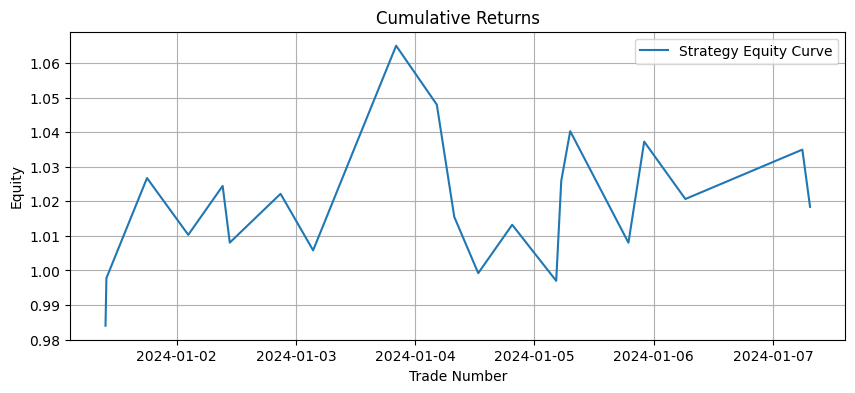

In [5]:
# 5. Analyze Results
print("Returns:\n", returns)
print("Mean Return:", returns.mean())
print("Number of Trades:", len(returns))

# Plot cumulative returns
cumulative = (1 + returns).cumprod()
plt.figure(figsize=(10, 4))
plt.plot(cumulative, label='Strategy Equity Curve')
plt.title('Cumulative Returns')
plt.ylabel('Equity')
plt.xlabel('Trade Number')
plt.grid(True)
plt.legend()
plt.show()